## **Import**

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 25.0 MB/s eta 0:00:00


In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_pickle("/content/drive/MyDrive/Semester 3/DL/Shiv/final_df.pkl")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## **Feature Engineering**

In [6]:
df = df[[
       #'subject_id_x', 'hadm_id', 'cxr_path', 'Atelectasis', 'Cardiomegaly',
       #'Edema', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'ecg_path',
       #'Hematocrit', 'Platelet Count', 'Creatinine', 'Potassium', 'Hemoglobin',
       #'White Blood Cells', 'MCHC', 'Red Blood Cells', 'MCV', 'MCH', 'RDW',
       #'Urea Nitrogen', 'Sodium', 'Chloride', 'Bicarbonate', 'Anion Gap',
       #'Glucose', 'Magnesium', 'Calcium, Total', 'Phosphate', 'INR(PT)', 'PT',
       #'PTT', 'Basophils', 'Neutrophils', 'Monocytes', 'Eosinophils',
       #'Lymphocytes', 'RDW-SD', 'H', 'L', 'I',
       #'Alanine Aminotransferase (ALT)', 'Asparate Aminotransferase (AST)',
       #'Lactate', 'Alkaline Phosphatase', 'Bilirubin, Total', 'pH', 'Albumin',
       #'Base Excess', 'pO2', 'Calculated Total CO2', 'pCO2',
       #'Absolute Neutrophil Count', 'Absolute Eosinophil Count',
       #'Absolute Monocyte Count', 'Absolute Basophil Count',
       #'Absolute Lymphocyte Count', 'Creatine Kinase (CK)',
       #'Immature Granulocytes',
       'Hematocrit_percentile',
       'Platelet Count_percentile', 'Creatinine_percentile',
       'Potassium_percentile', 'Hemoglobin_percentile',
       'White Blood Cells_percentile', 'MCHC_percentile',
       'Red Blood Cells_percentile', 'MCV_percentile', 'MCH_percentile',
       'RDW_percentile', 'Urea Nitrogen_percentile', 'Sodium_percentile',
       'Chloride_percentile', 'Bicarbonate_percentile', 'Anion Gap_percentile',
       'Glucose_percentile', 'Magnesium_percentile',
       'Calcium, Total_percentile', 'Phosphate_percentile',
       'INR(PT)_percentile', 'PT_percentile', 'PTT_percentile',
       'Basophils_percentile', 'Neutrophils_percentile',
       'Monocytes_percentile', 'Eosinophils_percentile',
       'Lymphocytes_percentile', 'RDW-SD_percentile', 'H_percentile',
       'L_percentile', 'I_percentile',
       'Alanine Aminotransferase (ALT)_percentile',
       'Asparate Aminotransferase (AST)_percentile', 'Lactate_percentile',
       'Alkaline Phosphatase_percentile', 'Bilirubin, Total_percentile',
       'pH_percentile', 'Albumin_percentile', 'Base Excess_percentile',
       'pO2_percentile', 'Calculated Total CO2_percentile', 'pCO2_percentile',
       'Absolute Neutrophil Count_percentile',
       'Absolute Eosinophil Count_percentile',
       'Absolute Monocyte Count_percentile',
       'Absolute Basophil Count_percentile',
       'Absolute Lymphocyte Count_percentile',
       'Creatine Kinase (CK)_percentile', 'Immature Granulocytes_percentile',
       'image',
       #'label_hadm_id', 'label', 'subject_id_y', 'hospital_expire_flag', 'dicom_id', 'discharge_location', 'admission_type',
       'admission_location',
       #'Consolidation', 'Enlarged Cardiomediastinum','Fracture', 'Lung Lesion', 'Pleural Other',  'Pneumothorax', 'Support Devices',
       'Pneumonia', 'race', 'gender', 'age',
       'ViewPosition']].copy()

In [7]:
def simplify_race(raw):
    if pd.isna(raw):
        return "Unknown/Refused"
    r = str(raw).strip().upper()

    # Unknown / refused
    if r in ["UNKNOWN", "UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER"]:
        return "Unknown/Refused"

    # White
    if r.startswith("WHITE") or r in ["PORTUGUESE"]:
        return "White"

    # Black
    if r.startswith("BLACK/") or r == "BLACK/AFRICAN":
        return "Black"

    # Hispanic / Latino
    if "HISPANIC" in r or "LATINO" in r or r in ["SOUTH AMERICAN"]:
        return "Hispanic/Latino"

    # Asian
    if r.startswith("ASIAN"):
        return "Asian"

    # Native American / Pacific Islander
    if r in ["AMERICAN INDIAN/ALASKA NATIVE", "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER"]:
        return "Other"   # or return r itself if you want distinct categories

    # Multiple / other
    if r in ["MULTIPLE RACE/ETHNICITY", "OTHER"]:
        return "Other"

    # Fallback
    return "Other"

df["race_grouped"] = df["race"].apply(simplify_race)


In [8]:
bins = [0, 40, 60, 80, 120]
labels = ["18–40", "40–60", "60–80", "80+"]

df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

In [9]:
df = df[['Hematocrit_percentile', 'Platelet Count_percentile',
       'Creatinine_percentile', 'Potassium_percentile',
       'Hemoglobin_percentile', 'White Blood Cells_percentile',
       'MCHC_percentile', 'Red Blood Cells_percentile', 'MCV_percentile',
       'MCH_percentile', 'RDW_percentile', 'Urea Nitrogen_percentile',
       'Sodium_percentile', 'Chloride_percentile', 'Bicarbonate_percentile',
       'Anion Gap_percentile', 'Glucose_percentile', 'Magnesium_percentile',
       'Calcium, Total_percentile', 'Phosphate_percentile',
       'INR(PT)_percentile', 'PT_percentile', 'PTT_percentile',
       'Basophils_percentile', 'Neutrophils_percentile',
       'Monocytes_percentile', 'Eosinophils_percentile',
       'Lymphocytes_percentile', 'RDW-SD_percentile', 'H_percentile',
       'L_percentile', 'I_percentile',
       'Alanine Aminotransferase (ALT)_percentile',
       'Asparate Aminotransferase (AST)_percentile', 'Lactate_percentile',
       'Alkaline Phosphatase_percentile', 'Bilirubin, Total_percentile',
       'pH_percentile', 'Albumin_percentile', 'Base Excess_percentile',
       'pO2_percentile', 'Calculated Total CO2_percentile', 'pCO2_percentile',
       'Absolute Neutrophil Count_percentile',
       'Absolute Eosinophil Count_percentile',
       'Absolute Monocyte Count_percentile',
       'Absolute Basophil Count_percentile',
       'Absolute Lymphocyte Count_percentile',
       'Creatine Kinase (CK)_percentile', 'Immature Granulocytes_percentile',
       'image', 'admission_location', 'Pneumonia',  'age', 'ViewPosition', 'race_grouped', 'age_group'
       #'race', 'gender',
       ]].copy()

## **XGB + CNN + MLP Fusion**

In [10]:
# Global seed
SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Train/Val/Test split (70/15/15)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Pneumonia"],
    random_state=SEED,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["Pneumonia"],
    random_state=SEED,
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


#  Lab binning
lab_cols = [col for col in train_df.columns if col.endswith("_percentile")]
for sparse_lab in ["H_percentile", "L_percentile", "I_percentile"]:
    if sparse_lab in lab_cols:
        lab_cols.remove(sparse_lab)

BIN_EDGES = np.array([0, 0.10, 0.25, 0.75, 0.90, 1.00], dtype=float)
NUM_LAB_BINS = len(BIN_EDGES) + 1
MISSING_BIN_IDX = NUM_LAB_BINS - 1


def bin_lab_series(series: pd.Series, edges=BIN_EDGES) -> pd.Series:
    values = series.values.astype(np.float64)
    bin_indices = np.digitize(values, edges, right=True) - 1
    bin_indices = np.where(bin_indices < 0, 0, bin_indices)
    bin_indices = np.where(
        bin_indices >= len(edges),
        len(edges) - 1,
        bin_indices,
    )
    bin_indices[np.isnan(values)] = MISSING_BIN_IDX

    return pd.Series(
        bin_indices.astype("int64"),
        index=series.index,
        name=series.name.replace("_percentile", "_bin"),
    )


for lab in lab_cols:
    train_df[lab.replace("_percentile", "_bin")] = bin_lab_series(train_df[lab])
    val_df[lab.replace("_percentile", "_bin")] = bin_lab_series(val_df[lab])
    test_df[lab.replace("_percentile", "_bin")] = bin_lab_series(test_df[lab])

train_df.drop(columns=lab_cols, inplace=True)
val_df.drop(columns=lab_cols, inplace=True)
test_df.drop(columns=lab_cols, inplace=True)

# Categorical encoding
cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]
vocabularies = {}

for col in cat_features:
    train_col = train_df[col].astype("object")
    val_col = val_df[col].astype("object")
    test_col = test_df[col].astype("object")

    train_vals = train_col.fillna("Unknown")
    train_cats = sorted(pd.Series(train_vals).dropna().unique())

    vocab = {"<UNK>": 0}
    for i, cat in enumerate(train_cats, start=1):
        vocab[cat] = i

    vocabularies[col] = vocab

    train_df[col] = train_vals.map(lambda x: vocab.get(x, 0)).astype("int64")
    val_df[col] = val_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")
    test_df[col] = test_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")

lab_bin_cols = [c for c in train_df.columns if c.endswith("_bin")]
cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]

for df_ in [train_df, val_df, test_df]:
    df_[lab_bin_cols] = df_[lab_bin_cols].astype("int64")
    df_[cat_features] = df_[cat_features].astype("int64")

# 3. Prepare tabular data for XGBoost
tab_cols = lab_bin_cols + cat_features + ["age_scaled"]

X_train_tab = train_df[tab_cols].to_numpy()
X_val_tab = val_df[tab_cols].to_numpy()
X_test_tab = test_df[tab_cols].to_numpy()

y_train = train_df["Pneumonia"].values
y_val = val_df["Pneumonia"].values
y_test = test_df["Pneumonia"].values

# Handle class imbalance for XGBoost
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    seed=SEED,
    n_jobs=1,
)

print("Training XGBoost on tabular features...")
xgb_model.fit(X_train_tab, y_train)

# XGBoost performance alone
val_proba_xgb = xgb_model.predict_proba(X_val_tab)[:, 1]
print("XGB Val AUC:", roc_auc_score(y_val, val_proba_xgb))

# Get XGB scores for train/val/test
train_xgb_score = xgb_model.predict_proba(X_train_tab)[:, 1].astype(np.float32)
val_xgb_score = xgb_model.predict_proba(X_val_tab)[:, 1].astype(np.float32)
test_xgb_score = xgb_model.predict_proba(X_test_tab)[:, 1].astype(np.float32)

#  PyTorch Dataset: image + XGB score

class CXRWithXGBDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, xgb_scores: np.ndarray):
        """
        data_df: dataframe with 'image' and 'Pneumonia'
        xgb_scores: numpy array of shape [N] with XGB probabilities for each row
        """
        self.data = data_df.reset_index(drop=True)
        self.xgb_scores = xgb_scores.astype(np.float32)
        assert len(self.data) == len(
            self.xgb_scores
        ), "DataFrame and xgb_scores length mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img = row["image"]
        if isinstance(img, np.ndarray):
            image = torch.from_numpy(img).float()
        else:
            image = img.detach().float()
        if image.ndim == 2:
            image = image.unsqueeze(0).repeat(3, 1, 1)
        elif image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        xgb_score = torch.tensor(
            [self.xgb_scores[idx]], dtype=torch.float32
        )
        label = torch.tensor(float(row["Pneumonia"]), dtype=torch.float32)

        return image, xgb_score, label
batch_size = 16
train_loader = DataLoader(
    CXRWithXGBDataset(train_df, train_xgb_score),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = DataLoader(
    CXRWithXGBDataset(val_df, val_xgb_score),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)
test_loader = DataLoader(
    CXRWithXGBDataset(test_df, test_xgb_score),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

#  CNN + XGB fusion model

class CNNXGBFusion(nn.Module):
    def __init__(
        self,
        d_img=128,
        fusion_width=128,
        dropout=0.3,
        freeze_cnn=False,
    ):
        super().__init__()

        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.img_fc = nn.Linear(256 * 20 * 20, d_img)

        if freeze_cnn:
            for p in self.image_cnn.parameters():
                p.requires_grad = False

        self.fusion = nn.Sequential(
            nn.Linear(d_img + 1, fusion_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_width, 1),
        )

    def forward(self, image, xgb_score):
        x = self.image_cnn(image)
        x = x.view(x.size(0), -1)
        z_img = self.img_fc(x)

        fused_input = torch.cat([z_img, xgb_score], dim=1)
        logit = self.fusion(fused_input)
        return logit


#  Training loop (CNN+XGB fusion)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNXGBFusion(
    d_img=128,
    fusion_width=128,
    dropout=0.3,
    freeze_cnn=False,
).to(device)

# Class imbalance handling for BCEWithLogits
pos_count = (train_df["Pneumonia"] == 1).sum()
neg_count = (train_df["Pneumonia"] == 0).sum()
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32, device=device)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


def train_fusion_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    num_epochs=30,
    patience=5,
):
    best_auc = 0.0
    best_state = None
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        #   Train
        model.train()
        running_loss = 0.0

        for images, xgb_scores, labels in train_loader:
            images = images.to(device)
            xgb_scores = xgb_scores.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(images, xgb_scores)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)

        #   Validation
        model.eval()
        val_loss = 0.0
        all_logits = []
        all_labels = []

        with torch.no_grad():
            for images, xgb_scores, labels in val_loader:
                images = images.to(device)
                xgb_scores = xgb_scores.to(device)
                labels = labels.to(device).unsqueeze(1)

                logits = model(images, xgb_scores)
                loss = loss_fn(logits, labels)
                val_loss += loss.item() * labels.size(0)

                all_logits.append(logits.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        all_logits = np.concatenate(all_logits).reshape(-1)
        all_labels = np.concatenate(all_labels).reshape(-1)

        val_probs = 1 / (1 + np.exp(-all_logits))
        val_auc = roc_auc_score(all_labels, val_probs)
        val_pred = (val_probs >= 0.5).astype(int)
        val_acc = accuracy_score(all_labels, val_pred)
        val_prec = precision_score(all_labels, val_pred, zero_division=0)
        val_rec = recall_score(all_labels, val_pred, zero_division=0)
        val_f1 = f1_score(all_labels, val_pred, zero_division=0)

        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss={avg_train_loss:.4f} | "
            f"Val Loss={avg_val_loss:.4f} | "
            f"AUC={val_auc:.4f} | "
            f"Acc={val_acc:.4f} | Prec={val_prec:.4f} | "
            f"Rec={val_rec:.4f} | F1={val_f1:.4f}"
        )

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping at epoch {epoch} "
                f"(no AUC improvement for {patience} epochs)."
            )
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_auc


print("Training CNN+XGB fusion model...")
model, best_val_auc = train_fusion_model(
    model, train_loader, val_loader, optimizer, loss_fn, num_epochs=30, patience=5
)
print(f"Best validation AUC (fusion): {best_val_auc:.4f}")

#  Test evaluation
model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for images, xgb_scores, labels in test_loader:
        images = images.to(device)
        xgb_scores = xgb_scores.to(device)

        logits = model(images, xgb_scores)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(labels.numpy())

all_probs = np.concatenate(all_probs).reshape(-1)
all_true = np.concatenate(all_true).reshape(-1)

test_pred = (all_probs >= 0.5).astype(int)

test_auc = roc_auc_score(all_true, all_probs)
test_acc = accuracy_score(all_true, test_pred)
test_prec = precision_score(all_true, test_pred, zero_division=0)
test_rec = recall_score(all_true, test_pred, zero_division=0)
test_f1 = f1_score(all_true, test_pred, zero_division=0)

print("\n=== Test Set Performance (CNN + XGB fusion) ===")
print(f"AUC      = {test_auc:.4f}")
print(f"Accuracy = {test_acc:.4f}")
print(f"Precision= {test_prec:.4f}")
print(f"Recall   = {test_rec:.4f}")
print(f"F1-score = {test_f1:.4f}")

cm = confusion_matrix(all_true.astype(int), test_pred)
print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification Report:")
print(classification_report(all_true.astype(int), test_pred, digits=4))


Train size: 1734, Val size: 372, Test size: 372
Training XGBoost on tabular features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Val AUC: 0.6096881798404641
Using device: cuda
Training CNN+XGB fusion model...
Epoch 001 | Train Loss=0.7276 | Val Loss=0.7299 | AUC=0.5993 | Acc=0.5484 | Prec=0.6061 | Rec=0.1143 | F1=0.1923
Epoch 002 | Train Loss=0.7041 | Val Loss=0.7179 | AUC=0.6067 | Acc=0.5699 | Prec=0.5319 | Rec=0.7143 | F1=0.6098
Epoch 003 | Train Loss=0.6833 | Val Loss=0.7279 | AUC=0.5949 | Acc=0.5699 | Prec=0.5610 | Rec=0.3943 | F1=0.4631
Epoch 004 | Train Loss=0.6611 | Val Loss=0.7233 | AUC=0.5844 | Acc=0.5296 | Prec=0.5000 | Rec=0.6800 | F1=0.5763
Epoch 005 | Train Loss=0.6313 | Val Loss=0.7434 | AUC=0.5873 | Acc=0.5376 | Prec=0.5069 | Rec=0.6286 | F1=0.5612
Epoch 006 | Train Loss=0.5858 | Val Loss=0.8552 | AUC=0.6002 | Acc=0.5914 | Prec=0.5852 | Rec=0.4514 | F1=0.5097
Epoch 007 | Train Loss=0.5300 | Val Loss=0.8157 | AUC=0.5785 | Acc=0.5403 | Prec=0.5090 | Rec=0.6457 | F1=0.5693
Early stopping at epoch 7 (no AUC improvement for 5 epochs).
Best validation AUC (fusion): 0.6067

=== Test Set Performance (

<Figure size 600x600 with 0 Axes>

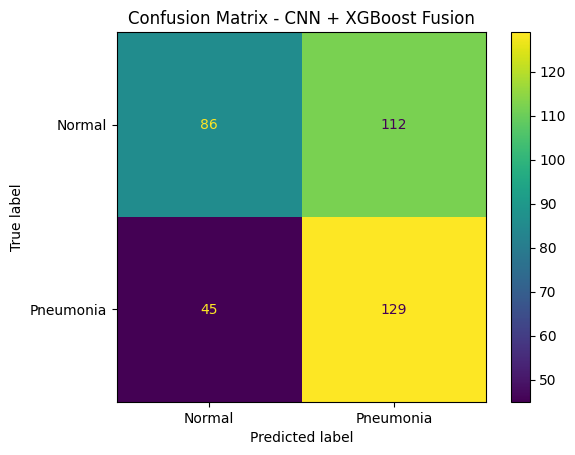

In [11]:


class_names = ["Normal", "Pneumonia"]

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d')
plt.title("Confusion Matrix - CNN + XGBoost Fusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

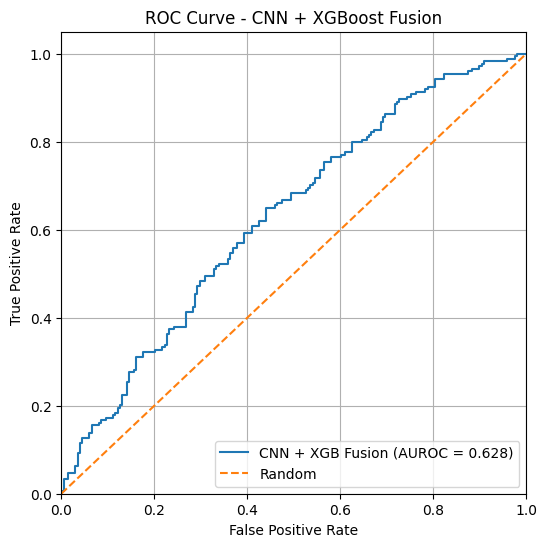

In [12]:

y_true = all_true.astype(int)
y_score = all_probs

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"CNN + XGB Fusion (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN + XGBoost Fusion")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XGB + CNN + Logistic Fusion**

In [16]:
#  Train/Val/Test split
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Pneumonia"],
    random_state=42,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["Pneumonia"],
    random_state=42,
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

#  Lab binning + categorical encoding + age scaling

# ---- Lab binning ----
lab_cols = [col for col in train_df.columns if col.endswith("_percentile")]
for sparse_lab in ["H_percentile", "L_percentile", "I_percentile"]:
    if sparse_lab in lab_cols:
        lab_cols.remove(sparse_lab)

BIN_EDGES = np.array([0, 0.10, 0.25, 0.75, 0.90, 1.00], dtype=float)
NUM_LAB_BINS = len(BIN_EDGES) + 1
MISSING_BIN_IDX = NUM_LAB_BINS - 1


def bin_lab_series(series: pd.Series, edges=BIN_EDGES) -> pd.Series:
    values = series.values.astype(np.float64)
    bin_indices = np.digitize(values, edges, right=True) - 1
    bin_indices = np.where(bin_indices < 0, 0, bin_indices)
    bin_indices = np.where(
        bin_indices >= len(edges),
        len(edges) - 1,
        bin_indices
    )
    bin_indices[np.isnan(values)] = MISSING_BIN_IDX

    return pd.Series(
        bin_indices.astype("int64"),
        index=series.index,
        name=series.name.replace("_percentile", "_bin"),
    )


for lab in lab_cols:
    train_df[lab.replace("_percentile", "_bin")] = bin_lab_series(train_df[lab])
    val_df[lab.replace("_percentile", "_bin")] = bin_lab_series(val_df[lab])
    test_df[lab.replace("_percentile", "_bin")] = bin_lab_series(test_df[lab])

train_df.drop(columns=lab_cols, inplace=True)
val_df.drop(columns=lab_cols, inplace=True)
test_df.drop(columns=lab_cols, inplace=True)

# ---- Categorical encoding with training vocab ----
cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]
vocabularies = {}

for col in cat_features:
    train_col = train_df[col].astype("object")
    val_col = val_df[col].astype("object")
    test_col = test_df[col].astype("object")

    train_vals = train_col.fillna("Unknown")
    train_cats = sorted(pd.Series(train_vals).dropna().unique())

    vocab = {"<UNK>": 0}
    for i, cat in enumerate(train_cats, start=1):
        vocab[cat] = i

    vocabularies[col] = vocab

    train_df[col] = train_vals.map(lambda x: vocab.get(x, 0)).astype("int64")
    val_df[col] = val_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")
    test_df[col] = test_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")

lab_bin_cols = [c for c in train_df.columns if c.endswith("_bin")]
cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]

for df_ in [train_df, val_df, test_df]:
    df_[lab_bin_cols] = df_[lab_bin_cols].astype("int64")
    df_[cat_features] = df_[cat_features].astype("int64")

#  Prepare tabular data for XGBoost
tab_cols = lab_bin_cols + cat_features

X_train_tab = train_df[tab_cols].to_numpy()
X_val_tab = val_df[tab_cols].to_numpy()
X_test_tab = test_df[tab_cols].to_numpy()

y_train = train_df["Pneumonia"].values
y_val = val_df["Pneumonia"].values
y_test = test_df["Pneumonia"].values

# Handle class imbalance for XGBoost
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

print("Training XGBoost on tabular features...")
xgb_model.fit(X_train_tab, y_train)

val_proba_xgb = xgb_model.predict_proba(X_val_tab)[:, 1]
print("XGB Val AUC:", roc_auc_score(y_val, val_proba_xgb))
train_xgb_score = xgb_model.predict_proba(X_train_tab)[:, 1].astype(np.float32)
val_xgb_score = xgb_model.predict_proba(X_val_tab)[:, 1].astype(np.float32)
test_xgb_score = xgb_model.predict_proba(X_test_tab)[:, 1].astype(np.float32)

#  PyTorch Dataset: image only (for CNN)

class CXRImageDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame):
        """
        data_df: dataframe with 'image' and 'Pneumonia'
        """
        self.data = data_df.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = row["image"]
        if isinstance(img, np.ndarray):
            image = torch.from_numpy(img).float()
        else:
            image = img.detach().float()

        if image.ndim == 2:
            image = image.unsqueeze(0).repeat(3, 1, 1)
        elif image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        label = torch.tensor(float(row["Pneumonia"]), dtype=torch.float32)

        return image, label


train_dataset = CXRImageDataset(train_df)
val_dataset = CXRImageDataset(val_df)
test_dataset = CXRImageDataset(test_df)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN model (image-only)

class CXRImageCNN(nn.Module):
    def __init__(self, d_img=128, dropout=0.3, freeze_cnn=False):
        super().__init__()
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.img_fc = nn.Linear(256 * 20 * 20, d_img)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_img, 1),
        )

        if freeze_cnn:
            for p in self.image_cnn.parameters():
                p.requires_grad = False

    def forward(self, image):
        x = self.image_cnn(image)
        x = x.view(x.size(0), -1)
        z_img = self.img_fc(x)
        logit = self.classifier(z_img)
        return logit

#  Training loop for CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CXRImageCNN(
    d_img=128,
    dropout=0.3,
    freeze_cnn=False,
).to(device)

# Class imbalance handling for BCEWithLogits
pos_count = (train_df["Pneumonia"] == 1).sum()
neg_count = (train_df["Pneumonia"] == 0).sum()
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32, device=device)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


def train_cnn_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    num_epochs=30,
    patience=5,
):
    best_auc = 0.0
    best_state = None
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(images)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        all_logits = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)

                logits = model(images)
                loss = loss_fn(logits, labels)
                val_loss += loss.item() * labels.size(0)

                all_logits.append(logits.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        all_logits = np.concatenate(all_logits).reshape(-1)
        all_labels = np.concatenate(all_labels).reshape(-1)

        val_probs = 1 / (1 + np.exp(-all_logits))
        val_auc = roc_auc_score(all_labels, val_probs)
        val_pred = (val_probs >= 0.5).astype(int)
        val_acc = accuracy_score(all_labels, val_pred)
        val_prec = precision_score(all_labels, val_pred, zero_division=0)
        val_rec = recall_score(all_labels, val_pred, zero_division=0)
        val_f1 = f1_score(all_labels, val_pred, zero_division=0)

        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss={avg_train_loss:.4f} | "
            f"Val Loss={avg_val_loss:.4f} | "
            f"AUC={val_auc:.4f} | "
            f"Acc={val_acc:.4f} | Prec={val_prec:.4f} | "
            f"Rec={val_rec:.4f} | F1={val_f1:.4f}"
        )

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping at epoch {epoch} "
                f"(no AUC improvement for {patience} epochs)."
            )
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_auc


print("Training CNN (image-only)...")
model, best_val_auc_cnn = train_cnn_model(
    model, train_loader, val_loader, optimizer, loss_fn, num_epochs=30, patience=5
)
print(f"Best validation AUC (CNN only): {best_val_auc_cnn:.4f}")

#  Helper: get CNN probabilities
def get_cnn_probs(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
            all_probs.append(probs)
            all_labels.append(labels.numpy().reshape(-1))
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels
# Create NON-SHUFFLED loaders for extracting probabilities
train_loader_no_shuffle = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader_no_shuffle = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_no_shuffle = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get CNN probabilities
train_proba_cnn, y_train_cnn = get_cnn_probs(model, train_loader_no_shuffle)
val_proba_cnn, y_val_cnn = get_cnn_probs(model, val_loader_no_shuffle)
test_proba_cnn, y_test_cnn = get_cnn_probs(model, test_loader_no_shuffle)

# Sanity check
assert np.array_equal(y_train_cnn.astype(int), y_train.astype(int))

#  Logistic Regression fusion: [p_cnn, p_xgb]

# Prepare fusion features
X_train_fusion = np.stack([train_proba_cnn, train_xgb_score], axis=1)
X_val_fusion = np.stack([val_proba_cnn, val_xgb_score], axis=1)
X_test_fusion = np.stack([test_proba_cnn, test_xgb_score], axis=1)

# Train logistic regression on train set
log_reg_fusion = LogisticRegression(
    class_weight="balanced",
    solver="lbfgs",
    max_iter=1000,
)
print("Training logistic regression fusion model...")
log_reg_fusion.fit(X_train_fusion, y_train)







Train size: 1734, Val size: 372, Test size: 372
Training XGBoost on tabular features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:28:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Val AUC: 0.6181000725163162
Using device: cuda
Training CNN (image-only)...
Epoch 001 | Train Loss=0.7341 | Val Loss=0.7215 | AUC=0.5947 | Acc=0.5511 | Prec=0.5222 | Rec=0.5371 | F1=0.5296
Epoch 002 | Train Loss=0.7157 | Val Loss=0.7301 | AUC=0.6018 | Acc=0.5699 | Prec=0.5773 | Rec=0.3200 | F1=0.4118
Epoch 003 | Train Loss=0.7065 | Val Loss=0.7233 | AUC=0.5997 | Acc=0.5511 | Prec=0.5211 | Rec=0.5657 | F1=0.5425
Epoch 004 | Train Loss=0.6951 | Val Loss=0.7186 | AUC=0.6069 | Acc=0.5645 | Prec=0.5367 | Rec=0.5429 | F1=0.5398
Epoch 005 | Train Loss=0.6821 | Val Loss=0.7257 | AUC=0.6005 | Acc=0.5430 | Prec=0.5140 | Rec=0.5257 | F1=0.5198
Epoch 006 | Train Loss=0.6500 | Val Loss=0.7576 | AUC=0.5827 | Acc=0.5376 | Prec=0.5128 | Rec=0.3429 | F1=0.4110
Epoch 007 | Train Loss=0.6118 | Val Loss=0.7923 | AUC=0.5920 | Acc=0.5645 | Prec=0.5520 | Rec=0.3943 | F1=0.4600
Epoch 008 | Train Loss=0.5764 | Val Loss=0.7770 | AUC=0.5742 | Acc=0.5538 | Prec=0.5228 | Rec=0.5886 | F1=0.5538
Epoch 009 | Trai

LogisticRegression(class_weight='balanced', max_iter=1000)

In [17]:
def evaluate_probs(y_true, probs, threshold=0.5, name="Model"):
    preds = (probs >= threshold).astype(int)
    auc = roc_auc_score(y_true, probs)
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    cm = confusion_matrix(y_true.astype(int), preds)

    print(f"\n=== {name} Performance ===")
    print(f"AUC      = {auc:.4f}")
    print(f"Accuracy = {acc:.4f}")
    print(f"Precision= {prec:.4f}")
    print(f"Recall   = {rec:.4f}")
    print(f"F1-score = {f1:.4f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true.astype(int), preds, digits=4))

In [18]:
# Test set performance
# XGB only
test_proba_xgb_only = test_xgb_score
evaluate_probs(y_test, test_proba_xgb_only, name="XGBoost (tabular only)")
# CNN only
evaluate_probs(y_test_cnn, test_proba_cnn, name="CNN (image only)")
# Fusion (logistic regression)
test_proba_fusion = log_reg_fusion.predict_proba(X_test_fusion)[:, 1]
evaluate_probs(y_test, test_proba_fusion, name="Logistic Regression Fusion (p_cnn + p_xgb)")


=== XGBoost (tabular only) Performance ===
AUC      = 0.6466
Accuracy = 0.5995
Precision= 0.5740
Recall   = 0.5575
F1-score = 0.5656
Confusion Matrix (rows=true, cols=pred):
[[126  72]
 [ 77  97]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6207    0.6364    0.6284       198
           1     0.5740    0.5575    0.5656       174

    accuracy                         0.5995       372
   macro avg     0.5973    0.5969    0.5970       372
weighted avg     0.5988    0.5995    0.5990       372


=== CNN (image only) Performance ===
AUC      = 0.6274
Accuracy = 0.5887
Precision= 0.5528
Recall   = 0.6322
F1-score = 0.5898
Confusion Matrix (rows=true, cols=pred):
[[109  89]
 [ 64 110]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6301    0.5505    0.5876       198
           1     0.5528    0.6322    0.5898       174

    accuracy                         0.5887       372
   macro avg     

<Figure size 500x500 with 0 Axes>

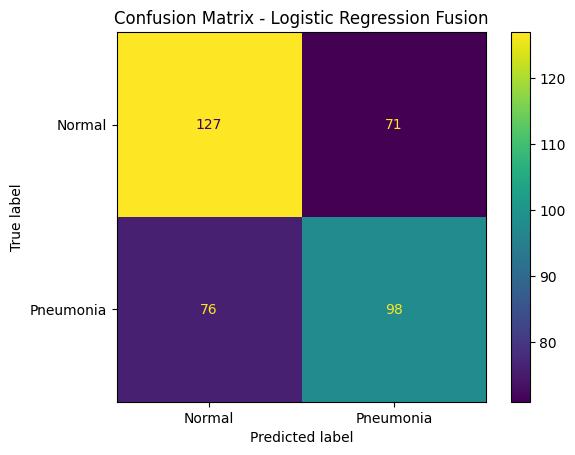

In [20]:
pred_fus = (probs_fus >= 0.5).astype(int)
cm_fus = confusion_matrix(y_true, pred_fus)

plt.figure(figsize=(5, 5))
disp_fus = ConfusionMatrixDisplay(confusion_matrix=cm_fus, display_labels=class_names)
disp_fus.plot(values_format='d')
plt.title("Confusion Matrix - Logistic Regression Fusion")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

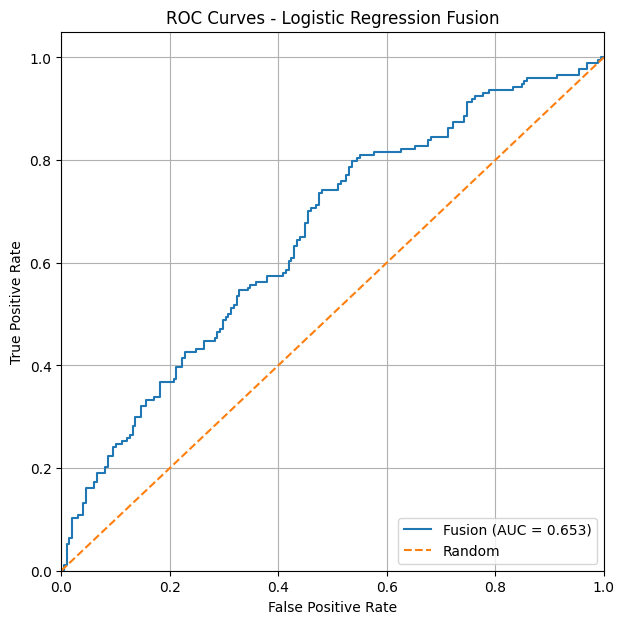

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ground truths and probabilities
y_true = y_test.astype(int)
probs_fus = test_proba_fusion            # Logistic regression fusion


fpr_fus, tpr_fus, _ = roc_curve(y_true, probs_fus)


auc_fus = roc_auc_score(y_true, probs_fus)

plt.figure(figsize=(7, 7))
plt.plot(fpr_fus, tpr_fus, label=f"Fusion (AUC = {auc_fus:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Logistic Regression Fusion")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## **Structured + Unstructured Data Modelled with only CNN**


In [13]:
# Global seed
SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Pneumonia"],
    random_state=SEED,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["Pneumonia"],
    random_state=SEED,
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

lab_cols = [col for col in train_df.columns if col.endswith("_percentile")]
for sparse_lab in ["H_percentile", "L_percentile", "I_percentile"]:
    if sparse_lab in lab_cols:
        lab_cols.remove(sparse_lab)

BIN_EDGES = np.array([0, 0.10, 0.25, 0.75, 0.90, 1.00], dtype=float)
NUM_LAB_BINS = len(BIN_EDGES) + 1
MISSING_BIN_IDX = NUM_LAB_BINS - 1


def bin_lab_series(series: pd.Series, edges=BIN_EDGES) -> pd.Series:
    values = series.values.astype(np.float64)

    bin_indices = np.digitize(values, edges, right=True) - 1
    bin_indices = np.where(bin_indices < 0, 0, bin_indices)

    bin_indices = np.where(
        bin_indices >= len(edges),
        len(edges) - 1,
        bin_indices,
    )

    bin_indices[np.isnan(values)] = MISSING_BIN_IDX

    return pd.Series(
        bin_indices.astype("int64"),
        index=series.index,
        name=series.name.replace("_percentile", "_bin"),
    )


for lab in lab_cols:
    train_df[lab.replace("_percentile", "_bin")] = bin_lab_series(train_df[lab])
    val_df[lab.replace("_percentile", "_bin")] = bin_lab_series(val_df[lab])
    test_df[lab.replace("_percentile", "_bin")] = bin_lab_series(test_df[lab])

train_df.drop(columns=lab_cols, inplace=True)
val_df.drop(columns=lab_cols, inplace=True)
test_df.drop(columns=lab_cols, inplace=True)

cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]
vocabularies = {}

for col in cat_features:
    train_col = train_df[col].astype("object")
    val_col = val_df[col].astype("object")
    test_col = test_df[col].astype("object")

    train_vals = train_col.fillna("Unknown")
    train_cats = sorted(pd.Series(train_vals).dropna().unique())

    vocab = {"<UNK>": 0}
    for i, cat in enumerate(train_cats, start=1):
        vocab[cat] = i

    vocabularies[col] = vocab

    train_df[col] = train_vals.map(lambda x: vocab.get(x, 0)).astype("int64")
    val_df[col] = val_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")
    test_df[col] = test_col.fillna("Unknown").map(lambda x: vocab.get(x, 0)).astype("int64")

lab_bin_cols = [c for c in train_df.columns if c.endswith("_bin")]
cat_features = ["admission_location", "ViewPosition", "race_grouped", "age_group"]

for df_ in [train_df, val_df, test_df]:
    df_[lab_bin_cols] = df_[lab_bin_cols].astype("int64")
    df_[cat_features] = df_[cat_features].astype("int64")


tab_cols = lab_bin_cols + cat_features + ["age_scaled"]

X_train_tab = train_df[tab_cols].to_numpy()
X_val_tab = val_df[tab_cols].to_numpy()
X_test_tab = test_df[tab_cols].to_numpy()

y_train = train_df["Pneumonia"].values
y_val = val_df["Pneumonia"].values
y_test = test_df["Pneumonia"].values


class CXRFullDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, tab_cols):
        """
        data_df: dataframe with 'image', 'Pneumonia', and tabular columns tab_cols
        """
        self.data = data_df.reset_index(drop=True)
        self.tab_cols = tab_cols

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img = row["image"]
        if isinstance(img, np.ndarray):
            image = torch.from_numpy(img).float()
        else:
            image = img.detach().float()

        if image.ndim == 2:
            image = image.unsqueeze(0).repeat(3, 1, 1)
        elif image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        tab_vals = row[self.tab_cols].values.astype(np.float32)
        tab_tensor = torch.from_numpy(tab_vals)

        label = torch.tensor(float(row["Pneumonia"]), dtype=torch.float32)

        return image, tab_tensor, label


batch_size = 16
train_dataset = CXRFullDataset(train_df, tab_cols)
val_dataset = CXRFullDataset(val_df, tab_cols)
test_dataset = CXRFullDataset(test_df, tab_cols)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


class CNNFullFusion(nn.Module):
    def __init__(
        self,
        d_img=128,
        fusion_width=128,
        dropout=0.3,
        freeze_cnn=False,
        num_tab_features=None,
    ):
        super().__init__()

        assert num_tab_features is not None, "num_tab_features must be provided."

        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.img_fc = nn.Linear(256 * 20 * 20, d_img)

        if freeze_cnn:
            for p in self.image_cnn.parameters():
                p.requires_grad = False

        self.d_img = d_img
        self.num_tab_features = num_tab_features

        self.fusion = nn.Sequential(
            nn.Linear(d_img + num_tab_features, fusion_width),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_width, 1),
        )

    def forward(self, image, tabular):
        x = self.image_cnn(image)
        x = x.view(x.size(0), -1)
        z_img = self.img_fc(x)

        fused_input = torch.cat([z_img, tabular], dim=1)
        logit = self.fusion(fused_input)
        return logit


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_tab_features = len(tab_cols)

model = CNNFullFusion(
    d_img=128,
    fusion_width=128,
    dropout=0.3,
    freeze_cnn=False,
    num_tab_features=num_tab_features,
).to(device)

pos_count = (train_df["Pneumonia"] == 1).sum()
neg_count = (train_df["Pneumonia"] == 0).sum()
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32, device=device)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


def train_cnn_full_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    num_epochs=30,
    patience=5,
):
    best_auc = 0.0
    best_state = None
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0

        for images, tabular, labels in train_loader:
            images = images.to(device)
            tabular = tabular.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(images, tabular)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        all_logits = []
        all_labels = []

        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images = images.to(device)
                tabular = tabular.to(device)
                labels = labels.to(device).unsqueeze(1)

                logits = model(images, tabular)
                loss = loss_fn(logits, labels)
                val_loss += loss.item() * labels.size(0)

                all_logits.append(logits.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        all_logits = np.concatenate(all_logits).reshape(-1)
        all_labels = np.concatenate(all_labels).reshape(-1)

        val_probs = 1 / (1 + np.exp(-all_logits))
        val_auc = roc_auc_score(all_labels, val_probs)
        val_pred = (val_probs >= 0.5).astype(int)
        val_acc = accuracy_score(all_labels, val_pred)
        val_prec = precision_score(all_labels, val_pred, zero_division=0)
        val_rec = recall_score(all_labels, val_pred, zero_division=0)
        val_f1 = f1_score(all_labels, val_pred, zero_division=0)

        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss={avg_train_loss:.4f} | "
            f"Val Loss={avg_val_loss:.4f} | "
            f"AUC={val_auc:.4f} | "
            f"Acc={val_acc:.4f} | Prec={val_prec:.4f} | "
            f"Rec={val_rec:.4f} | F1={val_f1:.4f}"
        )

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping at epoch {epoch} "
                f"(no AUC improvement for {patience} epochs)."
            )
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_auc


print("Training CNN+full-tabular model...")
model, best_val_auc = train_cnn_full_model(
    model, train_loader, val_loader, optimizer, loss_fn, num_epochs=30, patience=5
)
print(f"Best validation AUC (CNN+full-tabular): {best_val_auc:.4f}")


model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for images, tabular, labels in test_loader:
        images = images.to(device)
        tabular = tabular.to(device)

        logits = model(images, tabular)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(labels.numpy())

all_probs = np.concatenate(all_probs).reshape(-1)
all_true = np.concatenate(all_true).reshape(-1)

test_pred = (all_probs >= 0.5).astype(int)

test_auc = roc_auc_score(all_true, all_probs)
test_acc = accuracy_score(all_true, test_pred)
test_prec = precision_score(all_true, test_pred, zero_division=0)
test_rec = recall_score(all_true, test_pred, zero_division=0)
test_f1 = f1_score(all_true, test_pred, zero_division=0)

print("\n=== Test Set Performance (CNN + full tabular) ===")
print(f"AUC      = {test_auc:.4f}")
print(f"Accuracy = {test_acc:.4f}")
print(f"Precision= {test_prec:.4f}")
print(f"Recall   = {test_rec:.4f}")
print(f"F1-score = {test_f1:.4f}")

cm = confusion_matrix(all_true.astype(int), test_pred)
print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification Report:")
print(classification_report(all_true.astype(int), test_pred, digits=4))

test_df = test_df.copy()
test_df["cnn_full_prob"] = all_probs
test_df["cnn_full_pred"] = test_pred


Train size: 1734, Val size: 372, Test size: 372
Using device: cuda
Training CNN+full-tabular model...
Epoch 001 | Train Loss=0.7349 | Val Loss=0.7215 | AUC=0.6225 | Acc=0.5672 | Prec=0.5833 | Rec=0.2800 | F1=0.3784
Epoch 002 | Train Loss=0.7095 | Val Loss=0.7231 | AUC=0.6066 | Acc=0.5726 | Prec=0.5299 | Rec=0.8114 | F1=0.6411
Epoch 003 | Train Loss=0.7002 | Val Loss=0.7215 | AUC=0.6189 | Acc=0.5833 | Prec=0.6111 | Rec=0.3143 | F1=0.4151
Epoch 004 | Train Loss=0.6724 | Val Loss=0.7366 | AUC=0.6029 | Acc=0.5511 | Prec=0.5164 | Rec=0.7200 | F1=0.6014
Epoch 005 | Train Loss=0.6427 | Val Loss=0.7403 | AUC=0.5872 | Acc=0.5484 | Prec=0.5150 | Rec=0.6857 | F1=0.5882
Epoch 006 | Train Loss=0.5924 | Val Loss=0.7801 | AUC=0.6061 | Acc=0.5968 | Prec=0.6126 | Rec=0.3886 | F1=0.4755
Early stopping at epoch 6 (no AUC improvement for 5 epochs).
Best validation AUC (CNN+full-tabular): 0.6225

=== Test Set Performance (CNN + full tabular) ===
AUC      = 0.6414
Accuracy = 0.5887
Precision= 0.6129
Recall 

<Figure size 600x600 with 0 Axes>

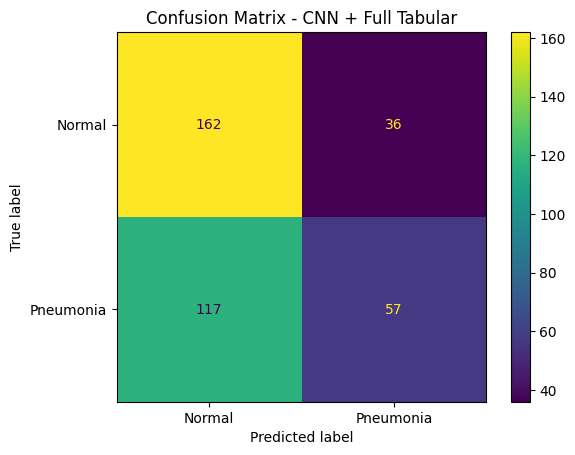

In [14]:
class_names = ["Normal", "Pneumonia"]

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d')
plt.title("Confusion Matrix - CNN + Full Tabular")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()

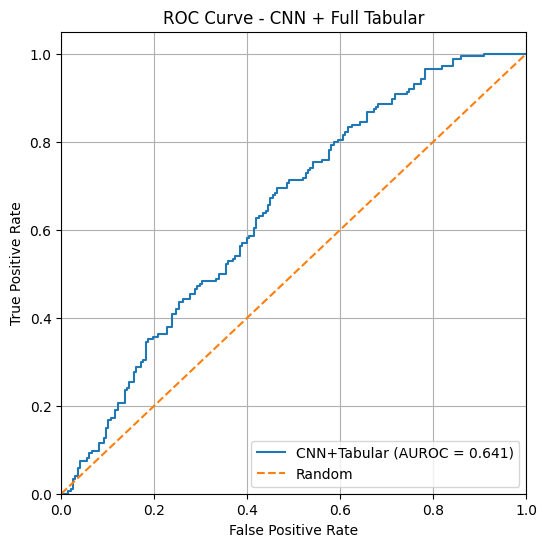

In [15]:
y_true = all_true.astype(int)
y_score = all_probs

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"CNN+Tabular (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN + Full Tabular")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()